# Imports

In [1]:
from copy import deepcopy
import fiona
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import rasterio.mask
from rasterio.crs import CRS
from rasterio.warp import Affine, transform_geom, calculate_default_transform, Resampling
import shapely 
from shapely.ops import unary_union
from shapely import affinity
from shapely import Polygon, MultiPolygon, box, Point
#from skimage.measure import block_reduce
from typing import List, Union

In [2]:
from data.config import CONFIG
from utilities.area import EARTH_RADIUS, show_stats, get_scales
from utilities.geojson import (
    filter_features,
    filter_features_by_list,
    filter_features_by_bounds,
    get_polygons, convert_dict_to_shapely
)
from utilities.plotting import (
    get_projection_xticks, get_projection_yticks, 
    plot_polygon, plot_polygons,
    plot_polygon_transform, plot_polygons_transform,
)

In [3]:
data_dir = '../../datasets/geospatial/'

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

https://data.metabolismofcities.org/dashboards/johannesburg/hub/harvesting/852/

In [ ]:
geojson_filepath = os.path.join(data_dir, 'geoBoundaries-BGD-ADM2-all/geoBoundaries-BGD-ADM2.geojson')
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
boundary = box(*(90.12642761306176, 23.5147887711267, 90.71610207693834, 24.054381124873363))
valid_features = filter_features_by_bounds(shape_data, boundary)
valid_ids = sorted([f['properties']['shapeName'] for f in valid_features])
print(valid_ids)

### Load

In [4]:
config = CONFIG["United States"]
feature_names = [props[0] for props in config["features"]["New York"]]
geojson_filepath = os.path.join(data_dir, 'borders', config["geojson filepath"])
prop_name = "shapeID"
region_name = "New York, USA"

In [5]:
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    if feature_names is None:
        features = shape_data['features']
    else:
        features = filter_features_by_list(shape_data, prop_name, feature_names)
        assert len(feature_names) == len(features)
admin_polygons = get_polygons(features, identifier=prop_name)

### Plotting

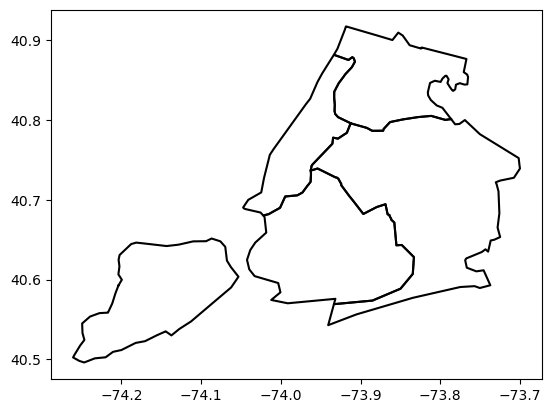

In [6]:
fig, ax = plt.subplots()
plot_polygons(ax, admin_polygons.values(), 'k-')
ax.set_aspect('equal')
ax.plot();

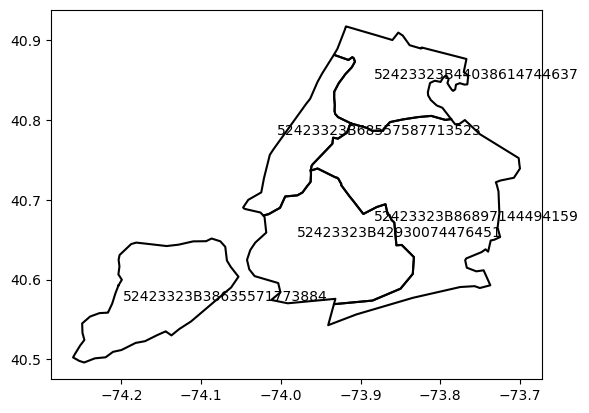

In [7]:
for key, polygon in admin_polygons.items():
    long_min, lat_min, long_max, lat_max = polygon.bounds
    long_avg = long_max * 0.3  + long_min * 0.7
    lat_avg = (lat_max + lat_min) / 2
    ax.text(long_avg, lat_avg, key)
fig

In [8]:
border_polygon = unary_union(list(admin_polygons.values()))

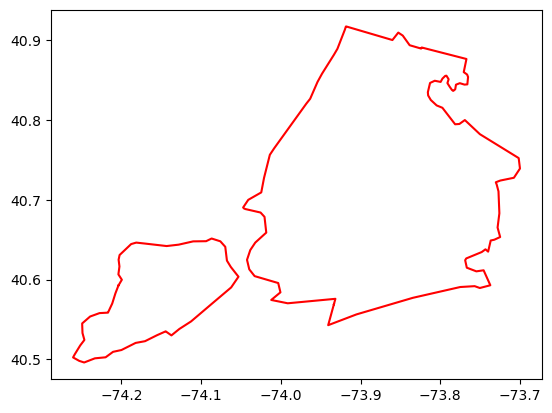

In [9]:
fig, ax = plt.subplots()
plot_polygon(ax, border_polygon, 'r-')
ax.set_aspect('equal')

reproject onto a transverse mercator to remove distortion (longitude lines stretched apart)

In [10]:
long_min, lat_min, long_max, lat_max = border_polygon.bounds
long_avg = (long_min + long_max) / 2
long_avg

-73.98031693449997

In [11]:
dst_crs = {
    'proj': 'tmerc',
    'lat_0': 0,
    'lon_0': long_avg,
    'k': 1/1000, # convert to km
    'x_0': 0,
    'y_0': 0,
    'ellps': 'WGS84',
    'units': 'm',
    'no_defs': True
}
src_crs = CRS.from_epsg(4326)

In [12]:
polygons_dst = transform_geom(src_crs, dst_crs, admin_polygons.values())
polygons_dst = dict(
    (name, convert_dict_to_shapely(geom)) for name, geom in zip(admin_polygons.keys(), polygons_dst)
)

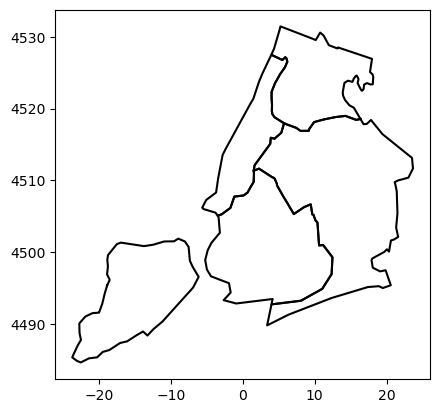

In [13]:
fig, ax = plt.subplots()
plot_polygons(ax, polygons_dst.values(), 'k-')
ax.set_aspect('equal')
ax.plot();

## Population Data

https://rasterio.readthedocs.io/en/latest/quickstart.html

https://hub.worldpop.org/geodata/listing?id=78

In [14]:
raster_filepath = os.path.join(data_dir, 'rasters', config["raster filepath"]) # population  / 3" where 1" is about 100m

In [15]:
with rasterio.open(raster_filepath) as dataset:
    print(dataset.name)
    print('No. of bands:', dataset.count)
    print(f'height: {dataset.height} ; width: {dataset.width}')
    print(dataset.bounds)
    print('Upper left: ', dataset.transform * (0, 0))
    print('Lower right:', dataset.transform * (dataset.width, dataset.height))
    print('Co-ordinate reference system:', dataset.crs)
    print(dataset.profile)

../../datasets/geospatial/rasters\usa_ppp_2020_constrained.tif
No. of bands: 1
height: 62976 ; width: 430711
BoundingBox(left=-179.147915935, bottom=18.91041679192, right=179.77791596263003, top=71.390416582)
Upper left:  (-179.147915935, 71.390416582)
Lower right: (179.77791596263003, 18.91041679192)
Co-ordinate reference system: EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 430711, 'height': 62976, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00083333333, 0.0, -179.147915935,
       0.0, -0.00083333333, 71.390416582), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [16]:
#img = dataset.read(1)

In [17]:
## Can be Very slow
# img[img<0] = 1
# img = np.log10(img+1)
# img[img==0] = np.nan

# fig, ax = plt.subplots()
# cax = ax.imshow(img)

## Clip to region of intersest

https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

In [18]:
cmap = plt.get_cmap('inferno')#, 10)

In [19]:
boundaries = [(box(*border_polygon.bounds))]
with rasterio.open(raster_filepath) as src:
    img_region, transform_region = rasterio.mask.mask(src, boundaries, crop=True)
    img_region[img_region < 0] = 0

In [20]:
img = img_region[0, :, :]
print(img.max())
print(img.sum())
print(img.mean())

2676.6382
11002674.0
32.198112


In [21]:
# img_downscaled = block_reduce(img, block_size=4, func=np.sum)
# print(img.sum(), img_downscaled.sum(), img_downscaled.sum()/img.sum())

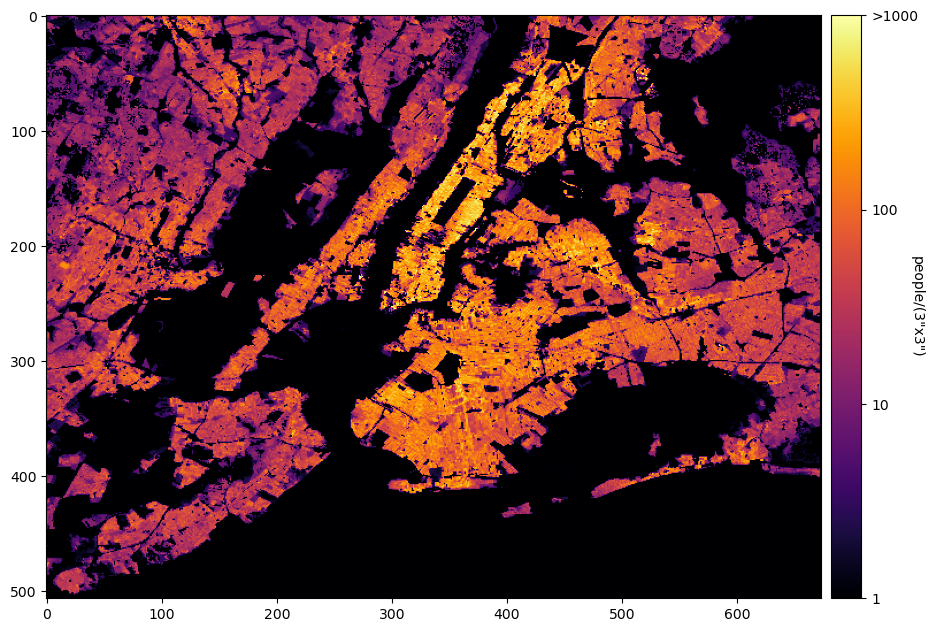

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
vmax = np.log10(1_000)

axis_image = ax.imshow(np.log10(img + 1), vmax=vmax, cmap=cmap)
#fig.colorbar(axis_image)

cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = fig.colorbar(axis_image, cbar_axis)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) # counts

ticks = np.log10([1, 10, 100, 1_000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

scales

In [23]:
height, width = img.shape
long_min, lat_min, long_max, lat_max = border_polygon.bounds
long_scale = 3600 * (lat_max - lat_min) / height
lat_scale = 3600 * (long_max - long_min) / width
print(f'{long_scale:.4f} arcseconds/pixel') 
print(f'{lat_scale:.4f} arcsecond/pixel') 
long_scale, lat_scale = get_scales(img.shape, border_polygon)
print(f'{long_scale:.2f} m/pixel') 
print(f'{lat_scale:.2f} m/pixel') 

2.9927 arcseconds/pixel
2.9943 arcsecond/pixel
92.44 m/pixel
70.11 m/pixel


units on axis

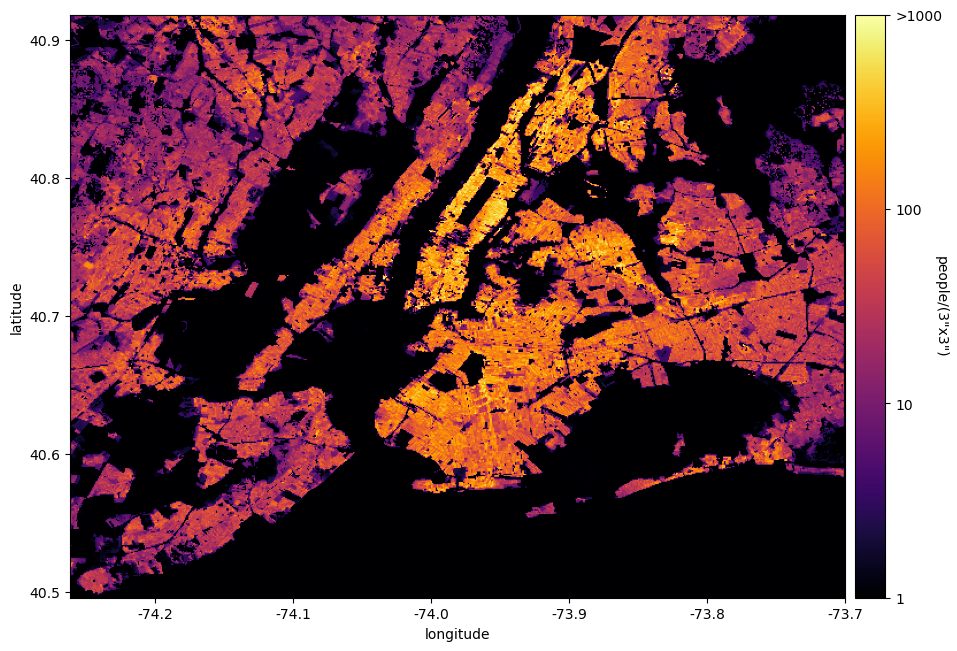

In [24]:
## long / lat
x_ticks, x_ticklabels = get_projection_xticks(transform_region, width, height)
y_ticks, y_ticklabels = get_projection_yticks(transform_region, width, height)
x_unit = 'longitude'
y_unit = 'latitude'

### km
# x_ticklabels = np.arange(0, lat_scale * width, 10_000)
# x_ticks = np.floor(x_ticklabels / lat_scale)
# x_ticklabels /= 1000
# y_ticklabels = np.arange(0, long_scale * height, 10_000)
# y_ticks = np.floor(y_ticklabels / long_scale)
# y_ticklabels /= 1000
# x_unit = 'km'
# y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
fig

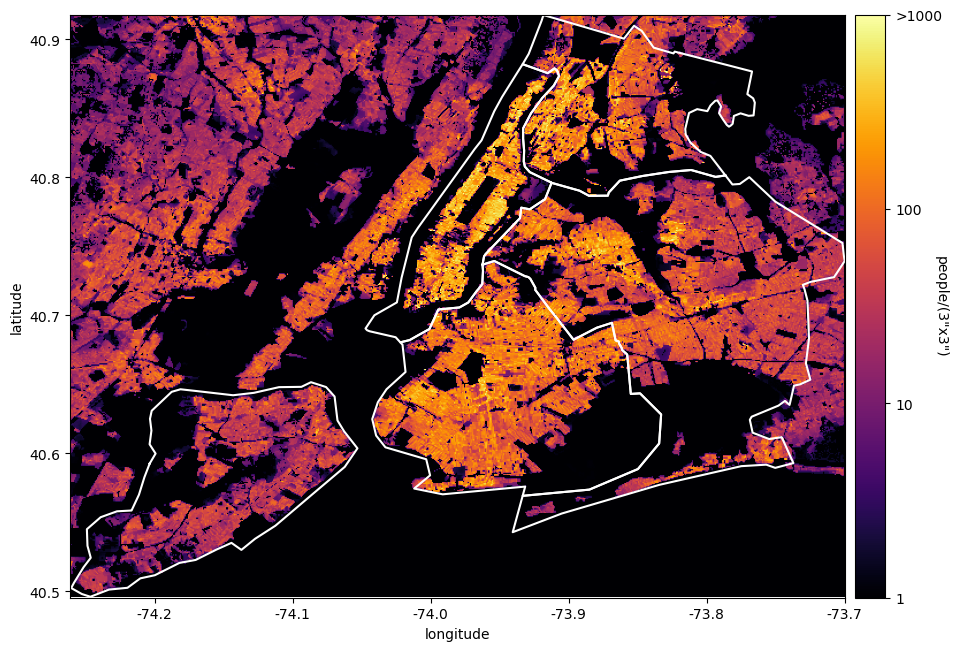

In [25]:
plot_polygons_transform(ax, admin_polygons.values(), transform_region.__invert__(), 'w-')
ax.set_xlim(left=0)
ax.set_xlim(right=width)
ax.set_ylim(bottom=height)
ax.set_ylim(top=0)
fig

Stats

In [26]:
with rasterio.open(raster_filepath) as dataset:
    show_stats(dataset, boundaries)
    print("-" * 30)
    show_stats(dataset, admin_polygons.values())

population: 11.00 million
max:        2677 people / pixel
area:       2214.57 km^2
density:    4968.32 people/km^2
------------------------------
population: 8.33 million
max:        2677 people / pixel
area:       922.16 km^2
density:    9036.84 people/km^2


### Reproject

Reproject onto a transverse mercator to remove distortion (longitude lines stretched apart)

- https://rasterio.readthedocs.io/en/latest/topics/reproject.html
- https://pygis.io/docs/d_raster_crs_intro.html
- http://pygis.io/docs/d_understand_crs_codes.html

In [27]:
height, width = img.shape
transform_dst, width_dst, height_dst = calculate_default_transform(
    dataset.crs, dst_crs, width, height, *border_polygon.bounds)
print((height_dst, width_dst))

(593, 602)


In [28]:
img_dst = np.zeros((height_dst, width_dst))
rasterio.warp.reproject(
    source=img_region[0, :, :],
    destination=img_dst,
    src_transform=transform_region,
    src_crs=dataset.crs,
    dst_transform=transform_dst,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear
);

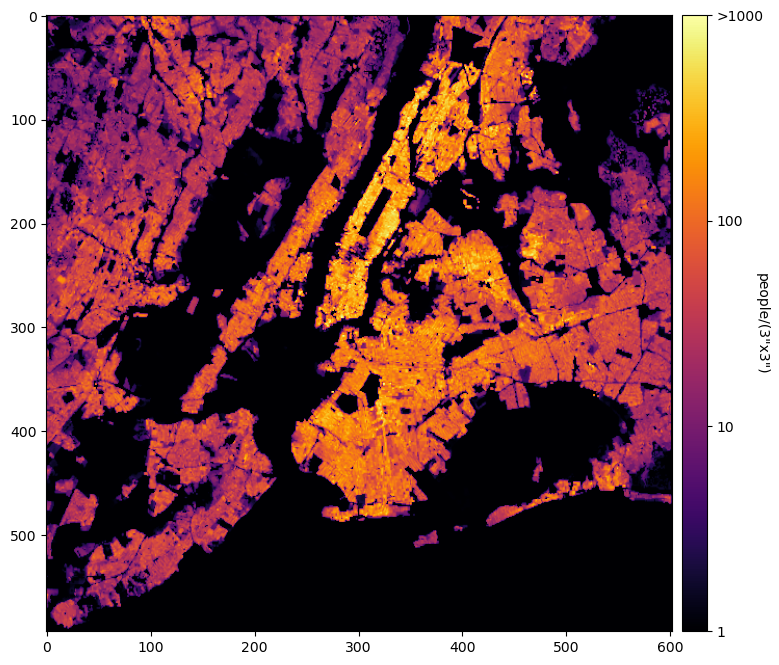

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
vmax = np.log10(1_000)

axis_image = ax.imshow(np.log10(img_dst + 1), vmax=vmax, cmap=cmap)
#fig.colorbar(axis_image)

cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(axis_image, cbar_axis)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) # counts

ticks = np.log10([1, 10, 100, 1_000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

boundaries

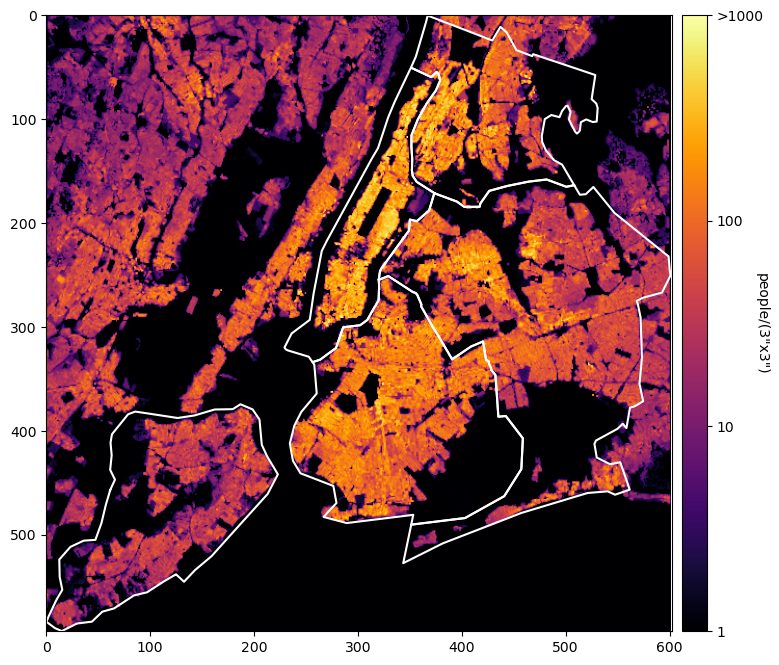

In [30]:
plot_polygons_transform(ax, polygons_dst.values(), transform_dst.__invert__(), 'w-')
ax.set_xlim(left=0)
ax.set_xlim(right=width_dst)
ax.set_ylim(bottom=height_dst)
ax.set_ylim(top=0)
fig

units on axis

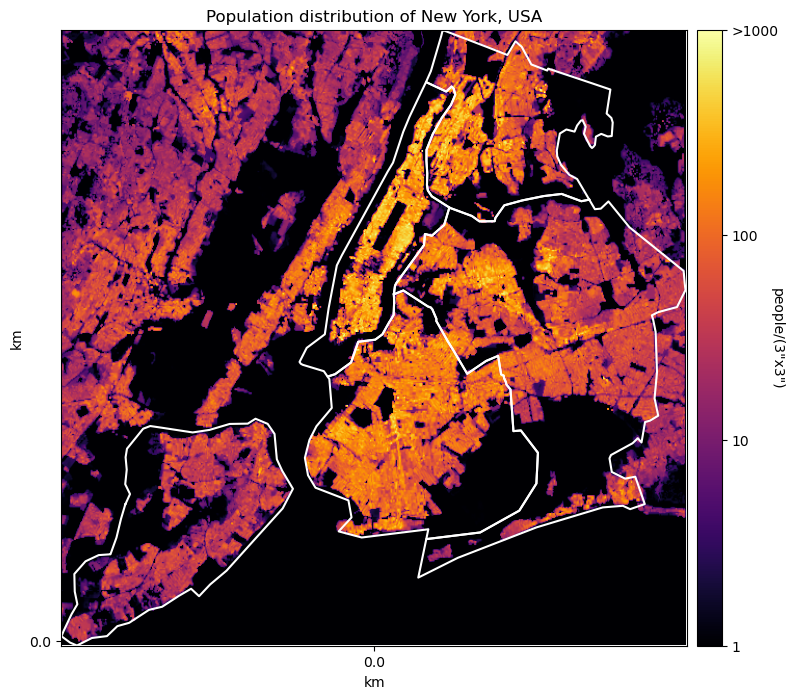

In [31]:
# distance from the central meridan. This always has a stretch factor stretch(long, lat).
# For a small region stretch=1 and so x_map=x_earth
x_ticks, x_ticklabels = get_projection_xticks(transform_dst, width_dst, height_dst, step_size=100)
# distance from the equator of the tranverse Mercator map. Only equivalent to earth distance at central meridan
# otherwise it is y_map * stretch(long) = y_earth
y_ticks, y_ticklabels = get_projection_yticks(transform_dst, width_dst, height_dst, step_size=100)
y_ticklabels -= y_ticklabels[0]

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_title(f'Population distribution of {region_name}')
fig

In [32]:
name = region_name.replace(' ', '').replace(',', '-')
outpath = os.path.join('images', 'densities', f"{name}_distribution_{cmap.name}.png")
fig.savefig(outpath, bbox_inches="tight")
print(f"Saved figure to {outpath}")

Saved figure to images\densities\NewYork-USA_distribution_inferno.png


## Compare to another city

In [33]:
config_other = CONFIG["United Kingdom"]
feature_names = [props[0] for props in config_other["features"]["London"]]
geojson_filepath = os.path.join(data_dir, 'borders', config_other["geojson filepath"])
other_name = 'London, UK'
other_raster_filepath = os.path.join(data_dir, 'rasters', config_other["raster filepath"])

In [34]:
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

if feature_names is None:
    features = shape_data['features']
else:
    features = filter_features_by_list(shape_data, 'shapeID', feature_names)
    assert len(feature_names) == len(features)
other_polygons = get_polygons(features)

In [35]:
print(border_polygon.bounds)
other_border = MultiPolygon(list(other_polygons.values()))
print(other_border.bounds)

(-74.26061251699997, 40.496111205000034, -73.70002135199996, 40.91758530000004)
(-0.509720585402481, 51.28676013985681, 0.333995664733011, 51.69187276890297)


In [36]:
with rasterio.open(other_raster_filepath) as src:
    other_img, transform_other = rasterio.mask.mask(src, other_polygons.values(), crop=True)
    other_img[other_img < 0] = 0
    print(f'----- {other_name} -----')
    show_stats(src, other_polygons.values())

# set a large enough boundary so that there is "empty space" for the other other raster
#boundary = box(27.1, -25.8, 28.6, -26.6) # Joburg, South Africa
#boundary = box(-1.2, 51.25, 0.33, 51.75) # London
other_width = other_border.bounds[2] - other_border.bounds[0]
gap = 0.05 # degrees
boundary = box(
    border_polygon.bounds[0] - other_width * 0.8,
    border_polygon.bounds[1] - gap,
    border_polygon.bounds[2] + gap,
    border_polygon.bounds[3] + gap
)
with rasterio.open(raster_filepath) as src:
    base_image, transform_base = rasterio.mask.mask(src, [boundary], crop=True)
    base_image[base_image < 0] = 0
    print(f'----- {region_name} Region -----')
    show_stats(src, [boundary])
    print(f'----- {region_name} -----')
    show_stats(src, admin_polygons.values())

----- London, UK -----
population: 9.19 million
max:        823 people / pixel
area:       1577.36 km^2
density:    5824.56 people/km^2
----- New York, USA Region -----
population: 13.80 million
max:        2677 people / pixel
area:       6283.44 km^2
density:    2196.41 people/km^2
----- New York, USA -----
population: 8.33 million
max:        2677 people / pixel
area:       922.16 km^2
density:    9036.84 people/km^2


reproject so that distortion for both is minimised

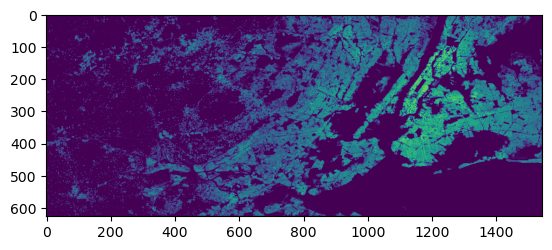

In [37]:
plt.imshow(np.log10(base_image[0, :, :] + 1))

In [38]:
base_crs = deepcopy(dst_crs)
other_long_min, other_lat_min, other_long_max, other_lat_max = other_border.bounds
other_long_avg = (other_long_min + other_long_max) / 2
other_crs = deepcopy(base_crs)
other_crs['lon_0'] = other_long_avg
src_crs = dataset.crs

In [39]:
height_base, width_base = base_image.shape[1:3]
transform_base_dst, width_base_dst, height_base_dst = calculate_default_transform(
        src_crs, base_crs, width_base, height_base, *boundary.bounds)
print((height_base, width_base))
print((height_base_dst, width_base_dst))

(627, 1544)
(790, 1476)


In [40]:
base_img_dst = np.zeros((height_base_dst, width_base_dst))
rasterio.warp.reproject(
    source=base_image[0, :, :],
    destination=base_img_dst,
    src_transform=transform_base,
    src_crs=src_crs,
    dst_transform=transform_base_dst,
    dst_crs=base_crs,
    resampling=Resampling.bilinear
);

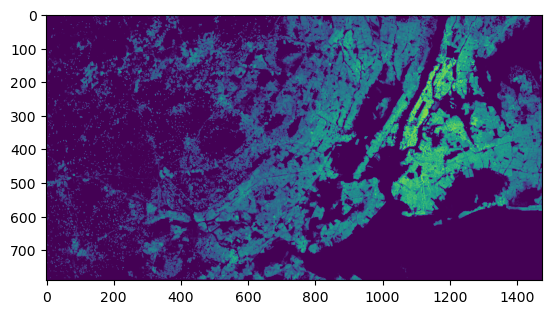

In [41]:
#plt.imshow(np.log10(base_image[0, :, :] + 1))
plt.imshow(np.log10(base_img_dst + 1));

In [42]:
height_other, width_other = other_img.shape[1:3]
transform_other_dst, width_other_dst, height_other_dst = calculate_default_transform(
        src_crs, other_crs, width_other, height_other, *other_border.bounds)
print((height_other, width_other))
print((height_other_dst, width_other_dst))

(487, 1014)
(687, 896)


https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html#affine

Affine:
$$
\begin{bmatrix}
x' \\ y' \\ 1
\end{bmatrix}
=
\begin{bmatrix}
a & b & c \\ d & e & f \\ 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x \\ y \\ 1
\end{bmatrix}
=
\begin{bmatrix}
ax + by + c \\ dx + ey + f \\ 1
\end{bmatrix}
$$

set other scale the same as base transform

In [43]:
scale_old = transform_other_dst.a
a = transform_base_dst.a
b = transform_base_dst.b
c = transform_other_dst.c
d = transform_base_dst.d
e = transform_base_dst.e
f = transform_other_dst.f
transform_other_dst = Affine(a, b, c, d, e, f)
# scale = (east - west) / width
# scale_ratio = [(east - west) / old_width] / [(east - west) / new_width] = new_width / old_width
scale_ratio = scale_old / transform_base_dst.a 
print(scale_ratio)
height_other_dst = np.round(height_other_dst * scale_ratio).astype(int)
width_other_dst = np.round(width_other_dst * scale_ratio).astype(int)
print((height_other_dst, width_other_dst))

0.8896315127831756
(611, 797)


In [44]:
other_img_dst = np.zeros((height_other_dst, width_other_dst))
rasterio.warp.reproject(
    source=other_img[0, :, :],
    destination=other_img_dst,
    src_transform=transform_other,
    src_crs=src_crs,
    dst_transform=transform_other_dst,
    dst_crs=other_crs,
    resampling=Resampling.bilinear
);

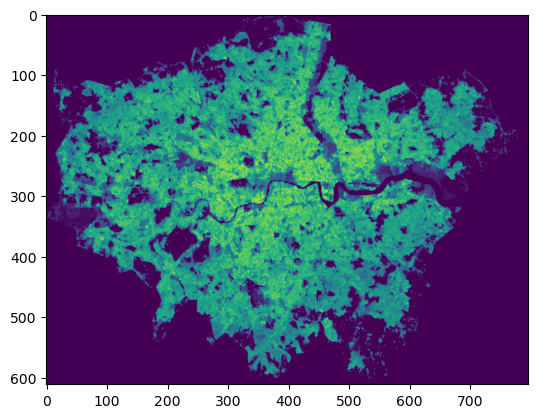

In [45]:
plt.imshow(np.log10(other_img_dst + 1));

insert other image in base image

In [46]:
origin_other = np.array((0, np.floor((height_base_dst - height_other_dst)/ 2).astype(int))) # far left, middle
origin_other

array([ 0, 89])

In [47]:
img_combined = base_img_dst.copy()
j_o, i_o = origin_other
i_n, j_n = other_img_dst.shape
img_combined[i_o:(i_o + i_n), j_o:(j_o + j_n)] = other_img_dst          

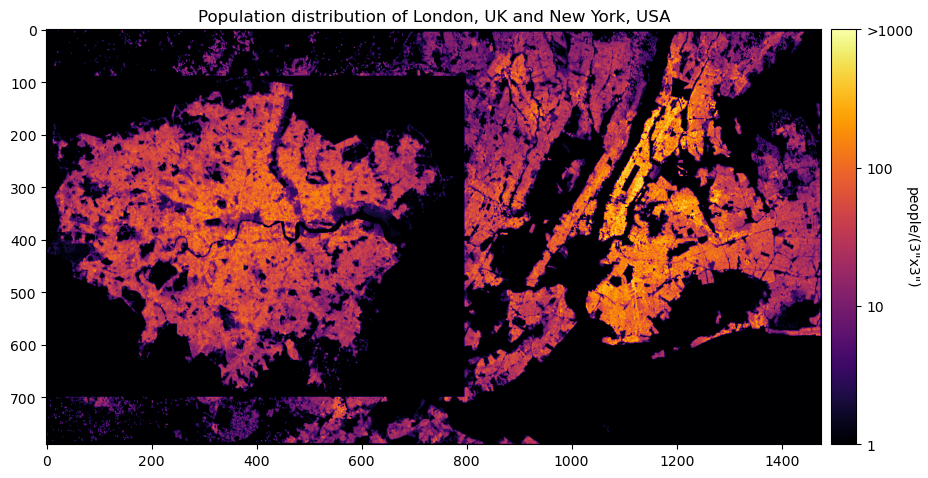

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(f'Population distribution of {other_name} and {region_name}')
vmax = np.log10(1_000)
img_axis = ax.imshow(np.log10(img_combined + 1), vmax=vmax, cmap=cmap)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(img_axis, cax)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) 
ticks = np.log10([1, 10, 100, 1000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

Boundaries

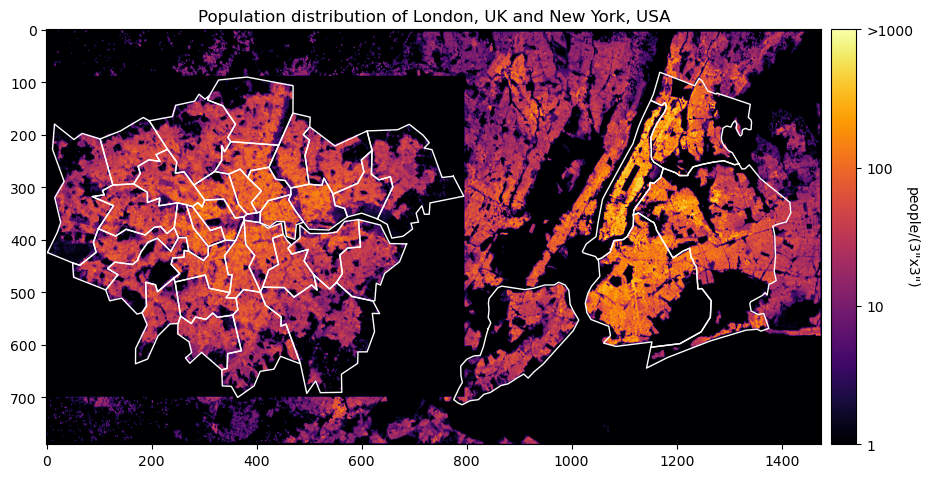

In [49]:
polygons_dst = transform_geom(src_crs, base_crs, admin_polygons.values())
polygons_dst = [convert_dict_to_shapely(geom) for geom in polygons_dst]
plot_polygons_transform(ax, polygons_dst, transform_base_dst.__invert__(), 'w-', linewidth=1.0)

polygons_dst = transform_geom(src_crs, other_crs, other_polygons.values())
polygons_dst = [convert_dict_to_shapely(geom) for geom in polygons_dst]
plot_polygons_transform(ax, polygons_dst, transform_other_dst.__invert__(), 'w-', offset=origin_other, linewidth=1.0)
    
height, width = img_combined.shape
fig

Set axis units

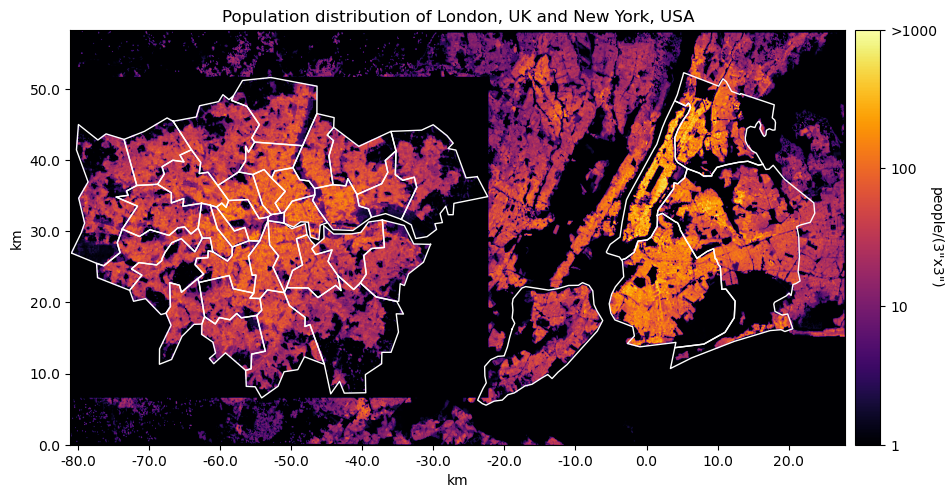

In [50]:
# distance from the central meridan. This always has a stretch factor stretch(long, lat).
# For a small region stretch=1 and so x_map=x_earth
x_ticks, x_ticklabels = get_projection_xticks(transform_base_dst, width_base_dst, height_base_dst, 10)
# distance from the equator of the tranverse Mercator map. Only equivalent to earth distance at central meridan
# otherwise it is y_map * stretch(long) = y_earth
y_ticks, y_ticklabels = get_projection_yticks(transform_base_dst, width_base_dst, height_base_dst)
y_ticklabels -= y_ticklabels[0]

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_xlabel('km')
ax.set_ylabel('km')
fig

admin boundaries

In [51]:
fig.savefig('images/london_ny_distribution.png', bbox_inches="tight")